# Анализ фрагмента реальной телеметрии БПЛА

## 1. Прочитать переданные данные в pandas, и проанализировать их:
* найти средние и отклонения (высоту, наклон...)
* построить графики (высоты, скорости)
* какой общий путь проделал БПЛА? Напишите функцию для вычисления пути.
* построить кривую (трек) маршрута по контрольным точкам (так как точки пишутся каждые 1-2 сек течение 3 ч, взять каждую 50-ю точку)*.
* к отчету приложить кривую маршрута.

__Импортируем библеотеку Pandas, загружаем данные из файла, и выводим первые 5 строк таблицы__

In [1]:
import pandas as pd

In [2]:
ds = pd.read_excel(r"Supercam S350.xlsx")

In [3]:
ds.head()

,image,date,time,lat,lon,alt,pitch,roll,azimuth,GPS direction,GPS speed
0,IMG_----.JPG,2020/04/28,03:31:42,61.687775,30.771736,22.9,-1.2,12.4,263.0,265.0,0.00
1,DSC00001.JPG,2020/04/28,03:31:42,61.687775,30.771736,22.9,-1.2,12.4,263.0,265.0,0.00
2,DSC00002.JPG,2020/04/28,03:31:43,61.687775,30.771736,23.1,-1.2,12.4,262.0,263.7,0.00
3,DSC00003.JPG,2020/04/28,03:31:45,61.687778,30.771736,23.1,-1.1,12.4,261.0,262.6,0.00
4,DSC00004.JPG,2020/04/28,03:41:43,61.674545,30.783556,294.7,0.3,0.7,166.0,152.8,88.92


### Находим средние значени и отклонения высоты, крена и тангажа

* Высота

In [4]:
# Создаем столбцы со средним значением и отклонением
ds = ds.assign(mean_alt = ds['alt'].mean())
ds = ds.assign(dev_alt = ds['mean_alt'] - ds['alt'])

# Определяем индекс столбца высоты
ind_alt = ds.columns.tolist().index("alt")

# Переносим столбец среднего значения
temp = ds.pop('mean_alt')
ds.insert(ind_alt+1, 'mean_alt', temp)

# Переносим столбец отклонений среднего значения
temp = ds.pop('dev_alt')
ds.insert(ind_alt+2, 'dev_alt', temp)

* Тангаж

In [5]:
# Создаем столбцы со средним значением и отклонением

ds = ds.assign(mean_pitch = ds['pitch'].mean())
ds = ds.assign(dev_pitch = ds['mean_pitch'] - ds['pitch'])

# Определяем индекс столбца тангажа
ind_pitch = ds.columns.tolist().index("pitch")

# Переносим столбец среднего значения
temp = ds.pop('mean_pitch')
ds.insert(ind_pitch+1, 'mean_pitch', temp)

# Переносим столбец отклонений среднего значения
temp = ds.pop('dev_pitch')
ds.insert(ind_pitch+2, 'dev_pitch', temp)

* Крен

In [6]:
# Создаем столбцы со средним значением и отклонением каждой характеристики 
ds = ds.assign(mean_roll = ds['roll'].mean())
ds = ds.assign(dev_roll = ds['mean_roll'] - ds['roll'])

# Определяем индекс столбца крена
ind_roll = ds.columns.tolist().index("roll")

# Переносим столбец среднего значения
temp = ds.pop('mean_roll')
ds.insert(ind_roll+1, 'mean_roll', temp)

# Переносим столбец отклонений среднего значения
temp = ds.pop('dev_roll')
ds.insert(ind_roll+2, 'dev_roll', temp)

__Выведем средние значения__

In [7]:
print("Средняя высота:", ds['alt'].mean())
print("Средний тангаж:", ds['pitch'].mean())
print("Средний крен:", ds['roll'].mean())

Средняя высота: 291.3804272766503
Средний тангаж: 0.6578118256366015
Средний крен: 0.8984031074665506


__Текущая версия таблицы с учетом ввода новых столбцов__

In [8]:
ds.head()

,image,date,time,lat,lon,alt,mean_alt,dev_alt,pitch,mean_pitch,dev_pitch,roll,mean_roll,dev_roll,azimuth,GPS direction,GPS speed
0,IMG_----.JPG,2020/04/28,03:31:42,61.687775,30.771736,22.9,291.380427,268.480427,-1.2,0.657812,1.857812,12.4,0.898403,-11.501597,263.0,265.0,0.00
1,DSC00001.JPG,2020/04/28,03:31:42,61.687775,30.771736,22.9,291.380427,268.480427,-1.2,0.657812,1.857812,12.4,0.898403,-11.501597,263.0,265.0,0.00
2,DSC00002.JPG,2020/04/28,03:31:43,61.687775,30.771736,23.1,291.380427,268.280427,-1.2,0.657812,1.857812,12.4,0.898403,-11.501597,262.0,263.7,0.00
3,DSC00003.JPG,2020/04/28,03:31:45,61.687778,30.771736,23.1,291.380427,268.280427,-1.1,0.657812,1.757812,12.4,0.898403,-11.501597,261.0,262.6,0.00
4,DSC00004.JPG,2020/04/28,03:41:43,61.674545,30.783556,294.7,291.380427,-3.319573,0.3,0.657812,0.357812,0.7,0.898403,0.198403,166.0,152.8,88.92


### Строим графики

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

Для построения графиков создадим отдельную таблицу и заносим в нее стобец datetime, заполняя данные в строковм формате

In [10]:
df = ds
# Конвертация столбцов в текст
df['date'] = df['date'].astype(str)
df['time'] = df['time'].astype(str)

# Объединение столбцов в строку с форматом даты и времени
df['datetime_str'] = df.pop('date') + ' ' + df.pop('time')

# Преобразование в формат даты и времени
df['datetime'] = pd.to_datetime(df['datetime_str'], format='%Y/%m/%d %H:%M:%S')

df.head()

,image,lat,lon,alt,mean_alt,dev_alt,pitch,mean_pitch,dev_pitch,roll,mean_roll,dev_roll,azimuth,GPS direction,GPS speed,datetime_str,datetime
0,IMG_----.JPG,61.687775,30.771736,22.9,291.380427,268.480427,-1.2,0.657812,1.857812,12.4,0.898403,-11.501597,263.0,265.0,0.00,2020/04/28 03:31:42,2020-04-28 03:31:42
1,DSC00001.JPG,61.687775,30.771736,22.9,291.380427,268.480427,-1.2,0.657812,1.857812,12.4,0.898403,-11.501597,263.0,265.0,0.00,2020/04/28 03:31:42,2020-04-28 03:31:42
2,DSC00002.JPG,61.687775,30.771736,23.1,291.380427,268.280427,-1.2,0.657812,1.857812,12.4,0.898403,-11.501597,262.0,263.7,0.00,2020/04/28 03:31:43,2020-04-28 03:31:43
3,DSC00003.JPG,61.687778,30.771736,23.1,291.380427,268.280427,-1.1,0.657812,1.757812,12.4,0.898403,-11.501597,261.0,262.6,0.00,2020/04/28 03:31:45,2020-04-28 03:31:45
4,DSC00004.JPG,61.674545,30.783556,294.7,291.380427,-3.319573,0.3,0.657812,0.357812,0.7,0.898403,0.198403,166.0,152.8,88.92,2020/04/28 03:41:43,2020-04-28 03:41:43


__График высоты__

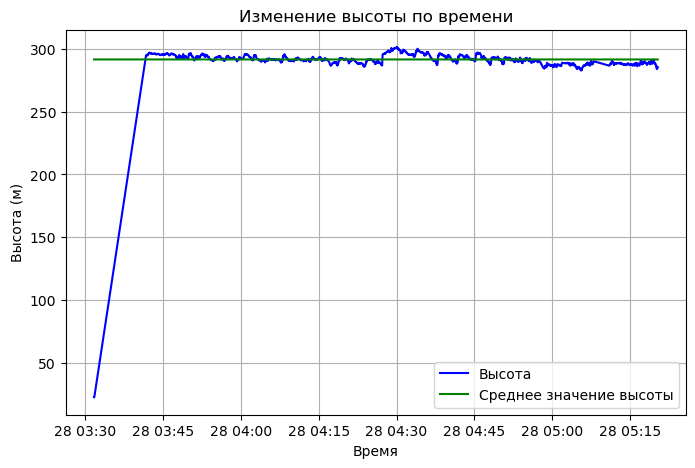

In [11]:
# Задаем поле графика
plt.figure(figsize=(8, 5))

# строим график высоты
sns.lineplot(x = 'datetime', y ='alt', data = df, color = "blue", label="Высота")

# строием график средней высоты
sns.lineplot(x = 'datetime', y ='mean_alt', data = df, color = "green" , label="Среднее значение высоты")

# настраиваем параметры графика
plt.title("Изменение высоты по времени")
plt.xlabel("Время")
plt.ylabel("Высота (м)")
plt.grid(True)
plt.legend(loc='best')
plt.show()

__График скорости__

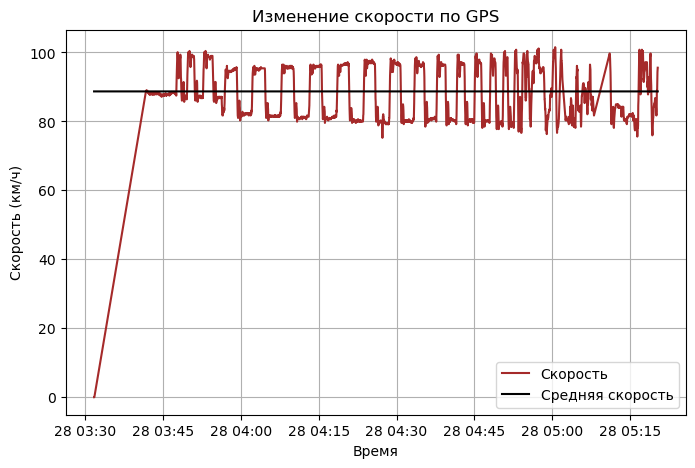

In [12]:
# Задаем поле графика
plt.figure(figsize=(8, 5))

# строим график скорости
sns.lineplot(x ='datetime', y='GPS speed',data = df, color='brown', label="Скорость")

# строием график средней скорости
sns.lineplot(x = 'datetime', y =df['GPS speed'].mean(), data = df, color = "black", label="Средняя скорость")

# настраиваем параметры графика
plt.title("Изменение скорости по GPS")
plt.xlabel("Время")
plt.ylabel("Скорость (км/ч)")
plt.grid(True)
plt.legend(loc='best')
plt.show()

### Расчет общего пути БПЛА

* Для расчета общего пути БПЛА всопольщуемся формулой гаверсинуса последовтельно для каждой пары точек из таблицы
* Для этого необходимо перевести координаты в радианы, использовать формулу гаверсинуса для вычисления центрального угла
* Финальным этапом вычисления является суммирование рсстояний в массиве

In [13]:
"""Алгоритм гаверсинуса используется для вычисления кратчайшего расстояния
   между двумя точками на поверхности Земли с учетом её сферической формы.
   lat1, lon1, lat2, lon2 - широта и долгота двух точек.
   R = 6 371 000 м - радиус Земли"""

import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    
    # переводим широты точки в радианы
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    
    # Вычисляем разницу между долготой и широтой и переводим в радианы
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    # Используем формулу гаверсинуса для вычисления промежуточного результата     
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    
    # Определяем через функцию арктангенса центральный угол в радианах между двумя точками
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Рассчитываем расстояние между двумя точками в метрах    
    distance = R * c
    return distance

# Создаем выборку координат в виде массивов
# при этом для первой точки исключаем последнюю координату, для второй - первую
lat1 = df['lat'].values[:-1]
lon1 = df['lon'].values[:-1]
lat2 = df['lat'].values[1:]
lon2 = df['lon'].values[1:]

# Вычисляем массив с расстояниями между парами точек
distances = haversine_distance(lat1, lon1, lat2, lon2)

# Находим общий путь
total_distance = np.sum(distances)
print(f"Общий путь, проделанный БПЛА, составляет: {total_distance:.2f} м")

Общий путь, проделанный БПЛА, составляет: 144219.17 м


### Функция построения кривой маршрута

* Для построение кривой маршрута используем библиотеку matplotlib.
* В качетсве значений по осям используем координаты широты и долготы из новой выборки df_50

__Сделаем выборку каждой 50-й точки из набора__

In [14]:
df_50 = df.iloc[[i for i in range(0, len(df)) if i % 50 == 0]]
df_50.head()

,image,lat,lon,alt,mean_alt,dev_alt,pitch,mean_pitch,dev_pitch,roll,mean_roll,dev_roll,azimuth,GPS direction,GPS speed,datetime_str,datetime
0,IMG_----.JPG,61.687775,30.771736,22.9,291.380427,268.480427,-1.2,0.657812,1.857812,12.4,0.898403,-11.501597,263.0,265.0,0.00,2020/04/28 03:31:42,2020-04-28 03:31:42
50,DSC00050.JPG,61.663074,30.793892,296.1,291.380427,-4.719573,0.6,0.657812,0.057812,0.6,0.898403,0.298403,172.0,161.8,88.20,2020/04/28 03:42:40,2020-04-28 03:42:40
100,DSC00100.JPG,61.650024,30.802099,295.2,291.380427,-3.819573,0.0,0.657812,0.657812,0.6,0.898403,0.298403,175.0,165.3,88.20,2020/04/28 03:43:42,2020-04-28 03:43:42
150,DSC00150.JPG,61.636894,30.809624,295.4,291.380427,-4.019573,0.0,0.657812,0.657812,0.5,0.898403,0.398403,175.0,165.4,87.48,2020/04/28 03:44:44,2020-04-28 03:44:44
200,DSC00200.JPG,61.623802,30.817146,296.4,291.380427,-5.019573,0.0,0.657812,0.657812,0.6,0.898403,0.298403,177.0,167.3,87.84,2020/04/28 03:45:46,2020-04-28 03:45:46


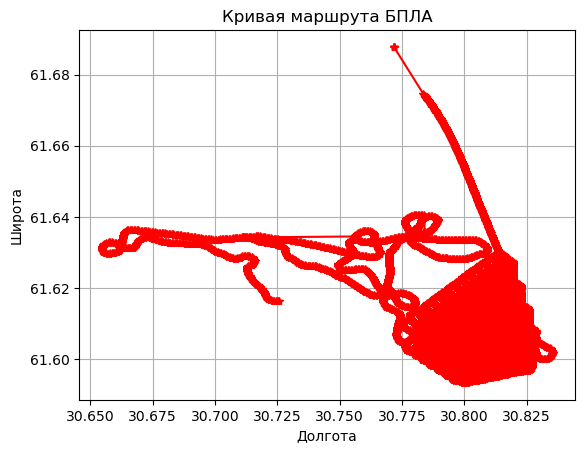

In [15]:
# Отображаем график
plt.plot(df['lon'], df['lat'], marker='*', linestyle='-', color='red')
plt.title("Кривая маршрута БПЛА")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.grid(True)
plt.show()

## 2. Задание в opencv:
* найти по координатам точек маршрута квадрант перемещений (наименьшую прямоугольную область, ограничивающую нитку маршрута). 
* сделать примерную геопривязку квадранта маршрута — нанести район полета на изображение (взять любую картографическую подложку, например, на картографических сервисах — Yandex, Google или OpenStreetMap или др. Выбрать масштаб карты-подложки с учетом масштаба перемещений БПЛА, карту ориентировать стандартно (вверх — направление на Север).
* К отчету приложить снимок экрана.

### Находим квадрант перемещений по координатам

* Для поиска квадранта по координатам WGS-84 маршрута их необходимо первести в радианы и на их основании вычислить координаты

In [16]:
import numpy as np

R = 6371 # радиус Земли

# переводим координаты маршрута в радианы
lat_rad = np.radians(df['lat'])
lon_rad = np.radians(df['lon'])

# находим среднее значение широты и переводим его в радианы
mean_lat = np.mean(df['lat'])
mean_lat_rad = np.radians(mean_lat)


__Создаем массивы x и y маршрута__
* При вычислении x учитываем cos значения средней широты для ликвидации ошибки, связанной с разным радиусом Земли на разной долготе

In [17]:
x = R * (lon_rad - lon_rad[0]) * np.cos(mean_lat_rad)
y = R * (lat_rad - lat_rad[0])

* Объединяем массивы x и y в двумерный массив координат маршрута

In [18]:
points = np.column_stack((x, y)).astype(np.float32)

__Далее с помощью OpenCV определяем квадрант, в который помещается маршрут__

In [19]:
import cv2

# находим минимальный прямоугольник, ограничивающий маршрут
rect = cv2.minAreaRect(points)

# далее определяем координаты полученного прямоугольника и преобразуем его в массив
box = cv2.boxPoints(rect)
box = np.int0(box)
print('Координаты центр', rect[0])
print('Высота, ширина, км', rect[1])
print('Угол поворота', rect[2])

Координаты центр (0.12345743179321289, -6.389178276062012)
Высота, ширина, км (8.888245582580566, 9.184962272644043)
Угол поворота 45.166351318359375


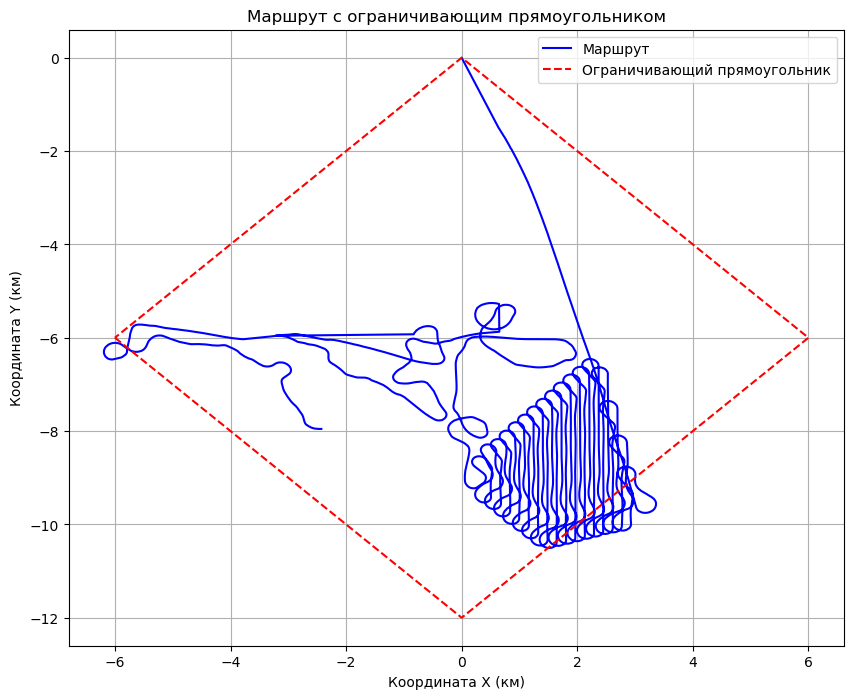

In [20]:
# Построение маршрута и ограничивающего прямоугольника
plt.figure(figsize=(10, 8))
# Маршрут строим по полученным массивам x и y
plt.plot(x, y, 'b-', label='Маршрут')
# Ограничивающий многоугольник строим по полученным выше координатам 
plt.plot(np.append(box[:, 0], box[0, 0]), np.append(box[:, 1], box[0, 1]), 'r--', label='Ограничивающий прямоугольник')
plt.legend()
plt.title('Маршрут с ограничивающим прямоугольником')
plt.xlabel('Координата X (км)')
plt.ylabel('Координата Y (км)')
plt.grid(True)
plt.show()

### Наносим маршрут на карту

__Для нанесения границы на карту понадобится библиотека folium__

In [21]:
import folium

* Создаем списки координат маршрута

In [22]:
latitudes = df['lat']
longitudes = df['lon']

* Создаем карту, центрированную на среднем местоположении фигуры маршрута

In [23]:
map_center = [mean_lat, np.mean(longitudes)] # используем средние значения долготы и широты
route_map = folium.Map(location=map_center, zoom_start=12) # начальный масштаб принимаем равным 12 

* Добавляем маршрут на карту

In [24]:
route_coords = list(zip(latitudes, longitudes)) # создаем список пар координат точек маршрута
folium.PolyLine(route_coords, color='blue', weight=2.5, opacity=1).add_to(route_map) # наносим линию маршрута на карту

* Сохранение карты в файл

In [25]:
route_map.save('route_map.html')

## Дополнительное задание:
* по результатам выполненного задания по привязке квадранта маршрута вписать кривую маршрута в обозначенный квадрант, правильно ее ориентировав по сторонам света.

### Нанесем квадрант маршрута на карту и сохраним в отдельный файл

__Для этого создадим квадрант в координатах WGS-84__

* Создаем массивы координат

In [29]:
longitudes_box = df['lon'].to_numpy()
latitudes_box = df['lat'].to_numpy()

* Объединяем массивы координат в двумерный массив координат маршрута

In [30]:
points_box = np.column_stack((latitudes_box, longitudes_box)).astype(np.float32)

* Далее с помощью OpenCV определяем квадрант, в который помещается маршрут

In [31]:
# находим минимальный прямоугольник, ограничивающий маршрут
rect_wgs = cv2.minAreaRect(points_box)

# далее определяем координаты полученного прямоугольника и преобразуем его в массив
box_wgs = cv2.boxPoints(rect_wgs)

In [33]:
# находим средние значения долготы и широты точек квадранта для размещения его в центре кратры
temp_box = box_wgs.reshape(1, 8)
lat_avg = lon_avg = 0
l = len(temp_box[0])
for i in range(l):
    if i % 2:
        lon_avg += temp_box[0][i]
    else:
        lat_avg += temp_box[0][i]
lat_avg /= (l / 2)
lon_avg /= (l / 2)

In [34]:
map_center_box = [lat_avg, lon_avg] # используем средние значения долготы и широты квадранта
box_map = folium.Map(location=map_center_box, zoom_start=12) # начальный масштаб принимаем равным 12 

In [35]:
box_coords = box_wgs.tolist() # создаем список пар координат точек маршрута
# box_coords = [tuple(i) for i in box_coords]
box_coords.append(box_coords[0]) # добавляем начальную точку для замкнутости контура
folium.PolyLine(route_coords, color='blue', weight=2.5, opacity=1).add_to(box_map) # наносим линию маршрута на карту
folium.PolyLine(box_coords, color='red', weight=3, opacity=1).add_to(box_map) # наносим линию границы маршрута на карту

In [36]:
box_map.save('route_map_with_box.html')

## Выводы: интерпретация полученных результатов

### Скриншот экрана с постренным маршрутом на карте и квадрантом области полета БПЛА

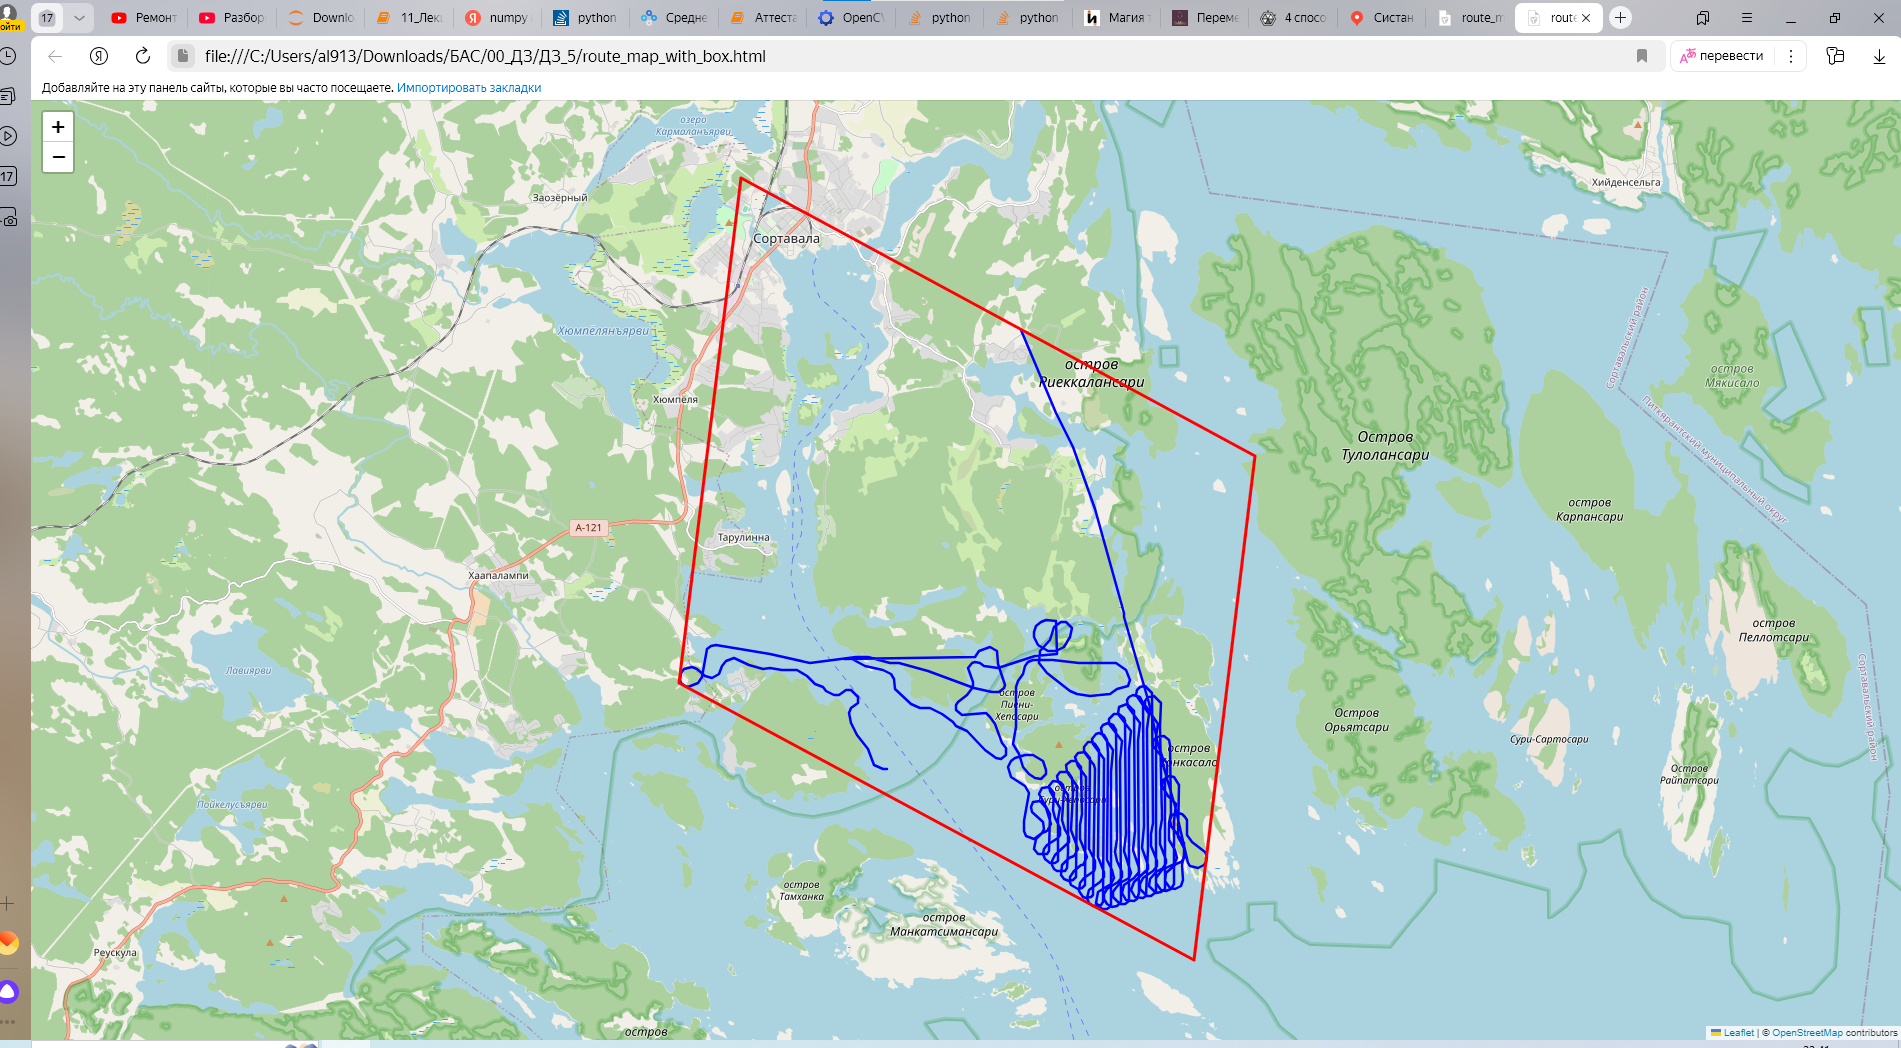

__С помощью библиотек Pandas, Numpy и, главное, OpenCV можно обрабатывать данные телеметрии, полученной от БПЛА:__
* __строить графики характеристик;__
* __определять маршруты БПЛА;__
* __строить квадрант области;__
* __рассчитывать дополнительные данные, такие как средняя скорость, отклонения наклона и т.п.__